In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LogisticRegression

In [3]:
def load_stock_data(folder_path):
    
    company_data = {}

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            company_name = filename[:-4]
            file_path = os.path.join(folder_path, filename)

            df = pd.read_csv(file_path, delimiter="\t", header=None,
                             names=["Date", "Movement %", "Open", "High", "Low", "Close", "Volume"])
            df["Date"] = pd.to_datetime(df["Date"])
            company_data[company_name] = df

    return company_data


In [4]:
folder = 'price/preprocessed'
company_data = load_stock_data(folder)

In [ ]:
def plot_movement(company_data, ticker, window=14):
    if ticker not in company_data:
        print(f"Ticker '{ticker}' not found in company data.")
        return

    df = company_data[ticker].copy()
    
    # Ensure the data is sorted by date
    df = df.sort_values(by='Date')

    # Compute the smoothed values
    df['Smoothed'] = df['Movement %'].rolling(window=window).mean()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['Movement %'], label='Raw Movement %', alpha=0.7)
    plt.plot(df['Date'], df['Smoothed'], label=f'Smoothed ({window}-day Avg)', color='orange', linewidth=2)

    plt.title(f"{ticker} - Raw vs Smoothed Movement % Over Time")
    plt.xlabel("Date")
    plt.ylabel("Movement %")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


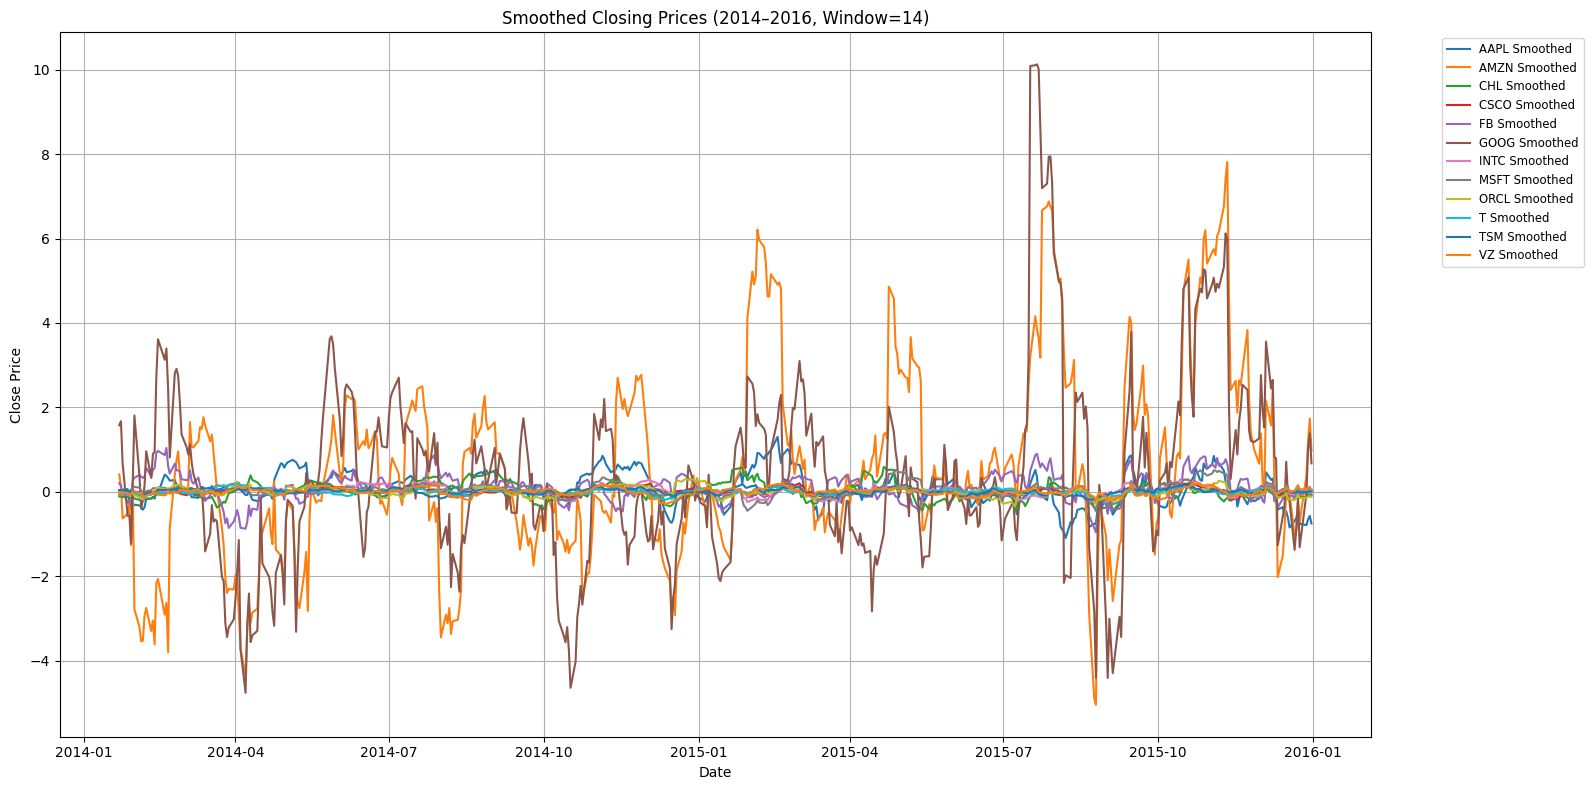

In [9]:
import matplotlib.pyplot as plt

def plot_all_closes(company_data, window=14):
    start_date = '2014-01-01'
    end_date = '2016-01-01'

    plt.figure(figsize=(16, 8))

    for ticker, df in company_data.items():
        df = df.copy()
        df['Date'] = pd.to_datetime(df['Date'])  # Ensure datetime format
        df = df.sort_values(by='Date')

        # Filter by date range
        df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

        if df.empty:
            continue  # Skip if no data in range

        df['Smoothed'] = df['Close'].rolling(window=window).mean()

        # Plot raw and smoothed close prices
        # plt.plot(df['Date'], df['Close'], label=f'{ticker} Raw', alpha=0.3)
        plt.plot(df['Date'], df['Smoothed'], label=f'{ticker} Smoothed', linewidth=1.5)

    plt.title(f"Smoothed Closing Prices (2014–2016, Window={window})")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.tight_layout()
    plt.show()

plot_all_closes(company_data, window=14)

In [ ]:
plot_movement(company_data, ticker='AAPL')

In [ ]:
plot_movement(company_data, ticker='AMZN')

In [ ]:
plot_movement(company_data, ticker='CHL')

In [ ]:
plot_movement(company_data, ticker='CSCO')

In [ ]:
plot_movement(company_data, ticker='FB')

In [ ]:
plot_movement(company_data, ticker='GOOG')

In [ ]:
plot_movement(company_data, ticker='INTC')

In [ ]:
plot_movement(company_data, ticker='MSFT')

In [ ]:
plot_movement(company_data, ticker='ORCL')

In [ ]:
plot_movement(company_data, ticker='T')

In [ ]:
plot_movement(company_data, ticker='TSM')

In [ ]:
plot_movement(company_data, ticker='VZ')

In [ ]:
# Normalize the sentiment score based on its label
def normalize_sentiment(label, score):
    if label == "positive":
        return score  # Keep positive scores as they are
    elif label == "neutral":
        return 0  # Neutral sentiment contributes 0 to the average
    elif label == "negative":
        return -score  # Negative sentiment becomes negative
    else:
        return 0  # Default to 0 for any unrecognized labels

def load_sentiment_data(sentiment_folder):
    sentiment_data = {}

    # Loop through all companies in the folder
    for company in os.listdir(sentiment_folder):
        print(f"Checking: {company}")  # debug
        company_folder = os.path.join(sentiment_folder, company)
        if not os.path.isdir(company_folder):
            print(f"Skipped {company} (not a directory)")
            continue

        daily_scores = []

        # Loop through all files for the company
        for file_name in os.listdir(company_folder):
            file_path = os.path.join(company_folder, file_name)

            # Ignore hidden or system files
            if file_name.startswith('.') or not os.path.isfile(file_path):
                continue

            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    scores = []
                    for line in f:
                        tweet = json.loads(line.strip())
                        sentiment = tweet.get("sentiment", {})
                        label = sentiment.get("label")
                        score = sentiment.get("score")
                        if score is not None and label:
                            # Normalize sentiment based on the label
                            normalized_score = normalize_sentiment(label, score)
                            scores.append(normalized_score)

                # If there are scores for the day, compute the average sentiment
                if scores:
                    avg_score = sum(scores) / len(scores)
                    date_str = file_name.replace('.json', '')  # Use filename as date
                    daily_scores.append({"Date": date_str, "Sentiment": avg_score})

            except Exception as e:
                print(f"Error reading {file_path}: {e}")

        # If daily scores are collected, process and store them
        if daily_scores:
            df = pd.DataFrame(daily_scores)
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df.dropna(subset=['Date'], inplace=True)  # Remove rows with invalid dates
            df.sort_values(by="Date", inplace=True)  # Sort by date
            sentiment_data[company] = df
            print(f"Loaded {len(df)} days for {company}")
        else:
            print(f"No data collected for {company}")

    return sentiment_data


# Load data
sentiment_folder = 'C:/Users/Owner/Desktop/Machine Learning/sentiment'
sentiment_data = load_sentiment_data(sentiment_folder)

# Show example
#if "AAPL" in sentiment_data:
    #print(sentiment_data["AAPL"].head())
#else:
    #print("AAPL data not found.")


In [ ]:
# Function to find missing dates for each company's sentiment data
def find_missing_dates(sentiment_data):
    # Define the full date range (Jan 1st 2014 to Dec 31st 2015)
    all_dates = pd.date_range(start="2014-01-01", end="2015-12-31", freq='D')

    # Loop through each company's data to check for missing dates
    for company, df in sentiment_data.items():
        # Convert the 'Date' column to a set of dates
        company_dates = set(df['Date'])

        # Find the missing dates by subtracting the company dates from the full date range
        missing_dates = set(all_dates) - company_dates

        if missing_dates:
            print(f"Missing dates for {company}: {sorted(missing_dates)}")
        else:
            print(f"All dates present for {company}")

In [ ]:
# Function to merge sentiment data with stock data
def merge_sentiment_and_stock_data(stock_data, sentiment_data, company):
    if company not in stock_data or company not in sentiment_data:
        print(f"Data not available for {company}")
        return None
    
    # Merge stock data with sentiment data on 'Date'
    stock_df = stock_data[company]
    sentiment_df = sentiment_data[company]
    
    # Merge the two dataframes based on 'Date'
    merged_df = pd.merge(stock_df, sentiment_df, on='Date', how='left')
    
    return merged_df

In [ ]:
def plot_sentiment_vs_stock_aligned_zero(company, stock_data, sentiment_data):
    # Merge stock and sentiment data
    merged_df = merge_sentiment_and_stock_data(stock_data, sentiment_data, company)
    if merged_df is None or merged_df.empty:
        print(f"No data to plot for {company}")
        return

    # Drop rows with NaN (optional: interpolate instead)
    merged_df = merged_df.dropna(subset=['Movement %', 'Sentiment'])

    # Get axis limits
    mov_min, mov_max = merged_df['Movement %'].min(), merged_df['Movement %'].max()
    sent_min, sent_max = merged_df['Sentiment'].min(), merged_df['Sentiment'].max()

    # Find ranges around zero so both zero lines align
    mov_range = max(abs(mov_min), abs(mov_max))
    sent_range = max(abs(sent_min), abs(sent_max))

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Stock Movement %
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Stock Movement (%)', color='tab:blue')
    ax1.plot(merged_df['Date'], merged_df['Movement %'], color='tab:blue', label='Stock Movement %')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(-mov_range, mov_range)  # Symmetrical around 0

    # Sentiment Score
    ax2 = ax1.twinx()
    ax2.set_ylabel('Sentiment Score', color='tab:green')
    ax2.plot(merged_df['Date'], merged_df['Sentiment'], color='tab:green', linestyle='--', label='Sentiment Score')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.set_ylim(-sent_range, sent_range)  # Also symmetrical

    # Grid and title
    ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Zero line for clarity
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    plt.title(f'{company}: Stock Movement % vs. Sentiment Score (Aligned Zero)')
    fig.tight_layout()
    plt.show()


In [ ]:
plot_sentiment_vs_stock_aligned_zero("AAPL", company_data, sentiment_data)


In [ ]:
def prepare_sentiment_features(df, window_size=14):
    df = df.copy()
    df = df.sort_values('Date').reset_index(drop=True)

    # Create the binary target: 1 if next day's Movement % > 0
    df['Target'] = df['Movement %'].shift(-1).apply(lambda x: 1 if x > 0 else 0)

    # Generate rolling sentiment features
    for i in range(window_size):
        df[f'sentiment_t-{i+1}'] = df['Sentiment'].shift(i + 1)

    # Drop rows with missing values (due to shifting)
    df = df.dropna(subset=[f'sentiment_t-{i+1}' for i in range(window_size)] + ['Target'])

    return df

In [ ]:
def train_sentiment_model(df, window_size=14):
    df = prepare_sentiment_features(df, window_size=window_size)

    # Features and target
    feature_cols = [f'sentiment_t-{i+1}' for i in range(window_size)]
    X = df[feature_cols]
    y = df['Target']

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    return model, X_test, y_test, y_pred, accuracy


In [ ]:
def evaluate_window_sizes(company, company_data, sentiment_data, min_window=1, max_window=50):
    """
    Evaluate different rolling window sizes for sentiment-based stock prediction.

    Args:
        company (str): Ticker symbol of the company (e.g., 'AAPL').
        company_data (DataFrame): Stock data for the company.
        sentiment_data (dict): Dictionary of sentiment DataFrames keyed by company.
        min_window (int): Minimum window size to evaluate (default 1).
        max_window (int): Maximum window size to evaluate (default 50).

    Returns:
        list: Sorted list of (window_size, accuracy) tuples, best first.
    """
    merged_df = merge_sentiment_and_stock_data(company_data, sentiment_data, company)
    results = []

    for window_size in range(min_window, max_window):
        try:
            model, X_test, y_test, y_pred, accuracy = train_sentiment_model(merged_df, window_size=window_size)
            results.append((window_size, accuracy))
            #print(f"Window size: {window_size} → Accuracy: {accuracy:.4f}")
        except Exception as e:
            print(f"Window size {window_size} failed: {e}")

    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

    print("\nRanking of window sizes by accuracy:")
    for rank, (window_size, accuracy) in enumerate(sorted_results, start=1):
        print(f"Rank {rank}: Window size {window_size} → Accuracy: {accuracy:.4f}")

    if sorted_results:
        best_window, best_acc = sorted_results[0]
        print(f"\n✅ {company} Best window size: {best_window} with accuracy: {best_acc:.4f}")
    else:
        print("\n⚠️ No valid window size produced results.")

    return sorted_results

In [ ]:
tickers = {'AAPL', 'AMZN', 'CHL', 'CSCO', 'FB', 'GOOG', 'INTC', 'MSFT', 'ORCL', 'T', 'TSM', 'VZ'}

for ticker in tickers:
    best_results = evaluate_window_sizes(ticker, company_data, sentiment_data, min_window=1, max_window=20)

In [ ]:
def prepare_price_features(df, window_size=14):
    df = df.copy()
    df = df.sort_values('Date').reset_index(drop=True)

    # Create binary target: 1 if next day's Movement % > 0
    df['Target'] = df['Movement %'].shift(-1).apply(lambda x: 1 if x > 0 else 0)

    price_cols = ['Movement %', 'Open', 'High', 'Low', 'Close', 'Volume']

    # Generate lagged features for each price-related column
    for col in price_cols:
        for i in range(window_size):
            df[f'{col}_t-{i+1}'] = df[col].shift(i + 1)

    # Drop rows with NaNs from shifting
    lagged_cols = [f'{col}_t-{i+1}' for col in price_cols for i in range(window_size)]
    df = df.dropna(subset=lagged_cols + ['Target'])

    return df


In [ ]:
def train_price_model(df, window_size=14):
    df = prepare_price_features(df, window_size=window_size)

    # Build the feature list
    price_cols = ['Movement %', 'Open', 'High', 'Low', 'Close']
    feature_cols = [f'{col}_t-{i+1}' for col in price_cols for i in range(window_size)]

    X = df[feature_cols]
    y = df['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    return model, X_test, y_test, y_pred, accuracy


In [ ]:
results = []
for ticker in tickers:
    print(f"Company: {ticker}")
    for window_size in range(1, 15):
        try:
            model, X_test, y_test, y_pred, accuracy = train_price_model(company_data[ticker], window_size=window_size)
            results.append((window_size, accuracy))
            print(f"Window size: {window_size} → Accuracy: {accuracy:.4f}")
        except Exception as e:
            print(f"Window size {window_size} failed: {e}")